In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from exp.nb_02 import *
import torch.nn.functional as F

### Initial Setup

#### Data

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
x_train, y_train, x_valid, y_valid = get_data()

In [6]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [70]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [11]:
model = Model(m, nh, 10)

In [12]:
pred = model(x_train)

#### Loss function: Cross entropy loss

Because multi-class label problem 

Output = preds

1. We take e^output for every class or label
2. We take the sum(e^outputs)
3. Prediction will be e^output/sum(e^outputs) - which adds up to 1

In [13]:
# Pytorch negative log-liklihood requires log softmax - hence the log
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [14]:
sm_pred = log_softmax(pred)

Essentially calculating negative log likelihood only requires the value of the target because the other part of the formula is just a multiplication with 0 - i.e. waste

The method below allows us to write negative log likelihood in a very concise manner

In [15]:
# explanation at Lesson 9 32 mins 
y_train[:3]

tensor([5, 0, 4])

In [16]:
# we actually only want the value in the 5th position because this is the target - see y_train above
sm_pred[0]

tensor([-2.3767, -2.3338, -2.3140, -2.5806, -2.1286, -2.2664, -2.3417, -2.3377,
        -2.1968, -2.2158], grad_fn=<SelectBackward>)

In [17]:
sm_pred[0][5]

tensor(-2.2664, grad_fn=<SelectBackward>)

In [18]:
# so to calculate the loss of the first 3 values we want the following indices
sm_pred[[0,1,2],[5,0,4]]

tensor([-2.2664, -2.3568, -2.1566], grad_fn=<IndexBackward>)

In [19]:
y_train.shape[0]

50000

In [20]:
def nll(input, target): return -input[range(target.shape[0]), target].mean() # range(target.shape[0]) selects all the rows

In [21]:
loss = nll(sm_pred, y_train)

In [23]:
loss

tensor(2.3114, grad_fn=<NegBackward>)

In [24]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [25]:
test_near(nll(log_softmax(pred), y_train), loss)

We're using LogSumExp - when using e^something numbers can get very large - when using floating point numbers they tend to get less accurate as they get very large - two numbers 1000 appart will be treated similarly by computers - which is bad when doing gradient calculations

The trick below allows us to do the same calculation without the numerical problems of floating point calculations

In [26]:
# numerical stability trick
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()    

In [27]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [28]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [29]:
test_near(nll(log_softmax(pred), y_train), loss)

In [31]:
# Pytorch implementaion
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

#### Which is the same as cross_entropy loss

In [32]:
test_near(F.cross_entropy(pred, y_train), loss)

#### Basic training loop

The training loop will repeat over the following steps

- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update the parameters with those gradients to make them a little bit better

In [33]:
loss_func = F.cross_entropy

We are grabbing the highest number from the output, with the index being the prediction and check if it's equal to the actual label

In [34]:
#export 
def accuracy(out, yb): return (torch.argmax(out,dim=1)==yb).float().mean()

In [35]:
bs=64 #batch size

xb = x_train[0:bs] # gets a mini-batch from x
preds = model(xb) # preds
preds[0], preds.shape

(tensor([-0.0896, -0.0466, -0.0269, -0.2935,  0.1585,  0.0208, -0.0546, -0.0506,
          0.0903,  0.0713], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [38]:
yb = y_train[0:bs]
loss_func(preds,yb)

tensor(2.3069, grad_fn=<NllLossBackward>)

In [39]:
accuracy(preds,yb)

tensor(0.1250)

Accuracy is giving random answers because we have yet to train the model

In [ ]:
def update():
    # calculate y_hat for linear model
    y_hat = x@a
    # calculate loss - compare actual with preds
    loss = mse(y, y_hat)
    # print loss every 10 steps
    if t % 10 == 0: print(loss)
    # calculate the gradients
    loss.backward()
    with torch.no_grad():
        # subtract learning rate * gradient from parameters
        a.sub_(lr* a.grad)
        # zero gradients
        a.grad.zero_()

In [40]:
lr = 0.5 # learning rate
epochs = 1 

In [44]:
model.layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [43]:
model.layers[0]

Linear(in_features=784, out_features=50, bias=True)

In [42]:
model.layers[0].weight

Parameter containing:
tensor([[-0.0040, -0.0176,  0.0214,  ..., -0.0065,  0.0094,  0.0067],
        [ 0.0006,  0.0218, -0.0286,  ...,  0.0134,  0.0088,  0.0283],
        [ 0.0094,  0.0034,  0.0159,  ...,  0.0251, -0.0079,  0.0337],
        ...,
        [-0.0077, -0.0226,  0.0337,  ...,  0.0083, -0.0023, -0.0147],
        [ 0.0334, -0.0334,  0.0104,  ..., -0.0036, -0.0153, -0.0232],
        [ 0.0302,  0.0253, -0.0328,  ..., -0.0179,  0.0316, -0.0287]],
       requires_grad=True)

In [46]:
# gradient descent from scratch
for epoch in range(epochs):
    # calculates number of mini batches // double backslash returns floating point number from integer division 
    for i in range((n-1)//bs + 1): 
        start_i = i * bs # 0 64
        end_i = start_i + bs # 64 128
        loss = loss_func(model(xb), yb) # calculate loss on batch
        
        loss.backward() # calculate gradients
        with torch.no_grad(): # allows for in-place changing of parameters
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_() # sets gradients to zero in place
                    l.bias.grad.zero_()                            
                    
                    # this is "slow" because we're going through each weight and bias individually

In [47]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

Only ran for a mini-batch because <code>xb = xtrain[:bs] and bs=64</code>

### Parameters



In [71]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))        

In [72]:
x_train.shape

torch.Size([50000, 784])

In [73]:
m

784

In [74]:
model = Model(m, nh, 10) # 10 outputs

In [75]:
model.named_children().type

AttributeError: 'generator' object has no attribute 'type'

From Pytorch docs:

Returns an iterator over immediate children modules, yielding both
the name of the module as well as the module itself.

Yields:
(string, Module): Tuple containing a name and child module

In [76]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [77]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [78]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [79]:
def fit():
    for epoch in range(epochs): # loop through epochs
        for i in range((n-1)//bs + 1): 
            start_i = i * bs # 0 64
            end_i = start_i + bs # 64 128
            loss = loss_func(model(xb), yb) # calculate loss on batch
        
            loss.backward() # calculate gradients
            with torch.no_grad(): # allows for in-place changing of parameters
                for p in model.parameters(): p -= p.grad * lr  
                model.zero_grad()    

In [80]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

In [81]:
accuracy(model(xb), yb)

tensor(1.)

super().\__init__ implements the functionality of the module below when we create a class (I think?)

on yield https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/

In [58]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v # _modules gives it a name and turns it into a Pytorch nn.Module
        super().__setattr__(k,v) # make fn call itself on init
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            # yield speeds up computation because we dont want to save a copy to a list before it gets used 
            for p in l.paramters(): yield p      

In [89]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10)]

In [96]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l) # give it a name and add as Pythorch module
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [97]:
model = Model(layers)

In [98]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

#### nn.ModuleList

In [99]:
# Pytorch implementation
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [100]:
model = SequentialModel(layers)

In [101]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

This is the equivalent to <code>nn.Sequential</code> from Pytorch

In [102]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params, self.lr=list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
    
    # note how there is a data.zero vs. the model.zero_grad() in the fit fn above
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

We're not using model.zero_grad() so that user can choose which gradients to optimize for e.g. gradual unfreezing or differential learning rates

In [103]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [104]:
opt = Optimizer(model.parameters())

In [105]:
# now we can do:
for epoch in range(epochs): # loop through epochs
        for i in range((n-1)//bs + 1): 
            start_i = i * bs # 0 64
            end_i = start_i + bs # 64 128
            loss = loss_func(model(xb), yb) # calculate loss on batch
        
            loss.backward() # calculate gradients
            opt.step()
            opt.zero_grad()            

In [106]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

In [107]:
#export 
from torch import optim

In [108]:
optim.SGD.step?? # has some extra functionality like weight_decay, momentum, dampening? nesterov?

In [109]:
# function to initialize model with SGD optimizer
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [110]:
model, opt = get_model() # init model
loss_func(model(xb), yb)

tensor(2.3249, grad_fn=<NllLossBackward>)

In [111]:
# now we can do:
for epoch in range(epochs): # loop through epochs
        for i in range((n-1)//bs + 1): 
            start_i = i * bs # 0 64
            end_i = start_i + bs # 64 128
            loss = loss_func(model(xb), yb) # calculate loss on batch
        
            loss.backward() # calculate gradients
            opt.step()
            opt.zero_grad()    

In [112]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

In [113]:
# Random test are usefull - so that these models can hint at problems
assert acc>0.7

These tests are written without a rixed random seed to check allow for model variability

#### Dataset 

# code is clunky when looping through mini-batches like this
<code>xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]</code>

# something like this instead would be more helpful
<code>xb, yb = train_ds[i*bs: i*bs+bs] </code> start_i :(up to) start_i + batch_size for every iteration

In [114]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [115]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [117]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [118]:
model, opt = get_model()

In [119]:
for epoch in range(epochs): # loop through epochs
        for i in range((n-1)//bs + 1): 
            xb, yb = train_ds[i*bs : i*bs+bs]
            pred = model(xb)
            loss = loss_func(pred, yb) # calculate loss on batch
        
            loss.backward() # calculate gradients
            opt.step()
            opt.zero_grad()  

In [120]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.0977, grad_fn=<NllLossBackward>), tensor(0.9375))

#### Dataloader

We want to change 

<code>for i in range((n-1)//bs + 1): xb, yb = train_ds[i\*bs : i\*bs+bs]</code>

to something more like

<code>for xb, yb in train_dl: ...</code>

In [130]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        # range fn moves from from 0 to the length of dataset with batch-size length steps in between
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

Yield is a co-routine used for situations when the same item needs to be called many times

In [131]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

<code>iter</code> generates the co-routine for yield

<code>next</code> grabs the next item from the yield co-routine

In [133]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs, )

tensor(3)

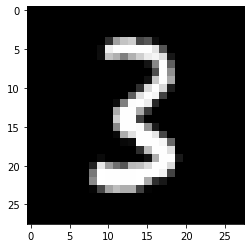

In [134]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [135]:
model, opt = get_model()

In [136]:
# @ 1h4 of FastAI course 2019 Lesson 9
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [137]:
fit()

In [138]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.2219, grad_fn=<NllLossBackward>), tensor(0.9531))

### We have a problem because we are always looping thorugh the training set in order

We'd like the training set to be in a random order, which should differ at each iteration. But the validation set shouldn't be randomized.

In [143]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        # only the length of the dataset is stored
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [157]:
len(train_ds[1][0])

784

In [140]:
small_ds = Dataset(*train_ds[:10])

In [146]:
small_ds.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [141]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [144]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([4, 3, 8]), tensor([2, 7, 6]), tensor([0, 9, 1]), tensor([5])]

In [158]:
def collate(b):
    xs, ys = zip(*b)
    # stacks tensor list into single list - so that a single "Dataload" can be returned
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    # the iter function is calling a co-routine on a co-routine    
    def __iter__(self):
        # grabs all indexes in sample and creates a list and stacks them into a single list of tensors 
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [159]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [160]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(train_ds, valid_samp)

tensor(5)

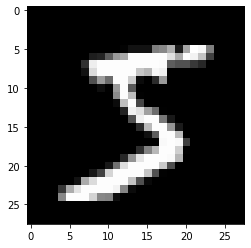

In [161]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

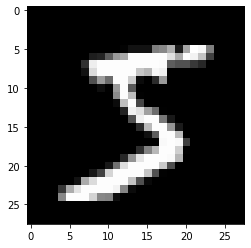

In [162]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(1)

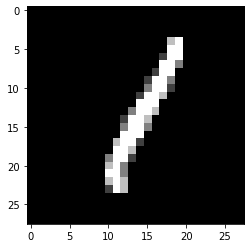

In [163]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

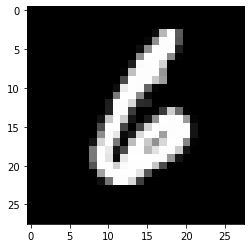

In [166]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

### It's returning random numbers

In [167]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1036, grad_fn=<NllLossBackward>), tensor(0.9531))

In [168]:
#export 
from torch.utils.data  import DataLoader, SequentialSampler, RandomSampler

In [ ]:
# @1h9mins

In [169]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=RandomSampler(valid_ds), collate_fn=collate)

In [170]:
model.opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0350, grad_fn=<NllLossBackward>), tensor(0.9844))

In [171]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [172]:
model.opt = get_model()
fit()
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0724, grad_fn=<NllLossBackward>), tensor(0.9844))

We didn't implement <code>num_workers</code> which calls multiple threads


### Validation

You should <strong>always</strong> have a validation set as well, in order to identify overfitting

We will calculate and print the validation loss at the end of each epoch.

We need to call <code>model.train()</code> before training and <code>model.eval()</code> before inference to insure the right behavior for <code>nn.BatchNorm2d</code> and <code>nn.Dropout</code>

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):